- try using the virtualenv on "source ~/Desktop/virtenv_deeprl/bin/activate" 
- using python3 so installed things using pip3

# Tutorial Taken from 

https://github.com/mimoralea/applied-reinforcement-learning/blob/master/notebooks/

In [8]:
import inspect
import numpy as np
import pandas as pd
import tempfile
import pprint
import json
import sys
import pandas as pd
from IPython.core.debugger import Tracer
import scipy.stats
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
import gym
from gym import wrappers


# Dynamic Programming Methods


In [7]:
mdir = tempfile.mkdtemp()
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, '/tmp/FrozenLake-v0',force=True) #force=True, replaces data in the folder
env.directory

[2017-08-27 12:24:44,411] Making new env: FrozenLake-v0
[2017-08-27 12:24:44,435] Clearing 24 monitor files from previous run (because force=True was provided)


'/tmp/FrozenLake-v0'

The env variable contains the problem specification. In DP methods, we assume these are known

In [8]:
A = range(env.action_space.n)
S = range(env.observation_space.n)
P = env.env.env.P
P[0][0]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]

Value iteration takes advantage of the bellman optimality equations. If you are following the optimal policy, the Bellman equations hold. If not, you can use the discrepancy between the current state's value and the next state's value to update the current state's value. Value iteration is the simplest form of this. 

For k iterations: 
$$ V(s)_k = max_a \sum_{s'} P(s',a,s)(R(s)+ \gamma V(s')_{k-1}) $$

Stop when 
$$ V(s)_k-V(s)_{k-1} < \epsilon$$

In [9]:
def value_iteration(A,S,P,epsilon = 0.0001,gamma = 0.99):
    '''Full Solves a MDP given the model of the environment
    Args:
        A: list action numbers
        S: list of state numbers 
        P: dictionary for transitions. keys are integers for states. P[s][a]. Then there is a list of tuples. 
        The tuple is (prob, next state, r, terminal?)
    
    '''

    # intialize value function
    V = np.random.random(len(S))
    
    for k in range(10000):
        V_prev = V.copy() 
        Q = np.zeros((len(A),len(S)),dtype=float)
        
        for s in S: # sample states in order 
            for a in A:
                for prob, s_prime, reward, done in P[s][a]:
                    Q[a,s]+= prob*(reward +gamma*V_prev[s_prime]* (not done))
                    
            V[s]=np.max(Q[:,s])
        
        if np.all(np.abs(V_prev - V) < epsilon): # check if any previous values haven't changed that much 
            break
            
    pi = np.argmax(Q,axis=0)
    return(pi,V)

So here, I'll actually run value iteration on the MDP and print out the learned policy and value function

optimal policy
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


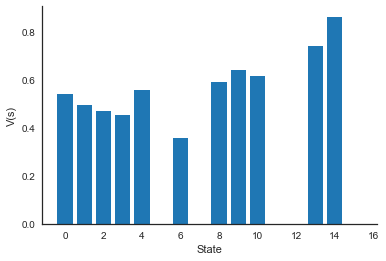

In [10]:
pi,V = value_iteration(A,S,P)
print('optimal policy')
print(pi)
sns.set_style('white')
sns.set_context('notebook')
plt.bar(np.arange(len(V)),V)
sns.despine()
plt.xlabel('State')
plt.ylabel('V(s)')

Here I use the policy to interact with the environment. Because the Monitor was set up, it'll save out a video in a json format. 

In [11]:
#P[state]

In [12]:
for _ in range(2000):
    state = env.reset()
    while True:
        #env.render()
        state, reward, done, info = env.step(pi[state])
        if done:
            break

[2017-08-27 12:24:49,517] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.59143.video000000.json
[2017-08-27 12:24:49,523] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.59143.video000001.json
[2017-08-27 12:24:49,529] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.59143.video000008.json
[2017-08-27 12:24:49,548] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.59143.video000027.json
[2017-08-27 12:24:49,576] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.59143.video000064.json
[2017-08-27 12:24:49,631] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.59143.video000125.json
[2017-08-27 12:24:49,711] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.59143.video000216.json
[2017-08-27 12:24:49,829] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.59143.video000343.json


In [13]:
env.close()
gym.upload('/tmp/FrozenLake-v0/',api_key='sk_PP2R5NblSSaI9sECHDhu1g')

[2017-08-27 12:24:52,385] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/FrozenLake-v0')
[2017-08-27 12:24:52,391] [FrozenLake-v0] Uploading 2000 episodes of training data
[2017-08-27 12:24:54,676] [FrozenLake-v0] Uploading videos of 11 training episodes (1468 bytes)
[2017-08-27 12:24:54,919] [FrozenLake-v0] Creating evaluation object from /tmp/FrozenLake-v0/ with learning curve and training video
[2017-08-27 12:24:55,094] 
****************************************************
You successfully uploaded your evaluation on FrozenLake-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_SijP6oVTGi35hCSjTttdA

****************************************************


# Q learning

Here we will interact with the environment in an online fasion. We will have to act to get a new observation. 


In [14]:
def Q_learning(env,alpha=0.9,gamma=0.9):
    '''This learning will learn a policy online.
    
    args:
        env: an RL environment

    '''

    # set-up
    A = range(env.action_space.n)
    S = range(env.observation_space.n)
    Q = np.random.random((len(S),len(A)))*2
    
    n_episodes = 10000
    rewards = np.zeros(n_episodes)
    
    epsilons = np.array([])
    for epi,episode in enumerate(range(n_episodes//2, -n_episodes//2, -1)):
        s = env.reset()

        
        # interact with environment until episode ends
        while True:
            
            # choose action in epislon greedy fashion w.r.t policy 
            epsilon = max(0, np.float(episode)/np.float(n_episodes*2.0))
            epp = scipy.stats.binom.rvs(p=epsilon,n=1)
            if epp==1:
                a = np.random.randint(len(A))
            else:
                a = np.argmax(Q[s,:])
            
            # act in the environment
            s_prime, reward, done, info = env.step(a)

            # update
            Q[s,a]+= alpha*(reward + gamma*np.max(Q[s_prime,:])*(not done)-Q[s,a])

            # go to next state 
            s = s_prime 
            
            if done:
                break
        rewards[epi]=reward
        epsilons = np.append(epsilons,epsilon)
    
    return(Q,rewards,epsilons)
    
    

In [15]:
mdir = tempfile.mkdtemp()
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, '/tmp/FrozenLake-v0-Q-learning',force=True) #force=True, replaces data in the folder
env.directory

[2017-08-27 12:24:57,476] Making new env: FrozenLake-v0
[2017-08-27 12:24:57,486] Clearing 40 monitor files from previous run (because force=True was provided)


'/tmp/FrozenLake-v0-Q-learning'

In [16]:
Q,rewards,epsilons = Q_learning(env)


[2017-08-27 12:24:58,347] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.1.59143.video000000.json
[2017-08-27 12:24:58,353] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.1.59143.video000001.json
[2017-08-27 12:24:58,368] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.1.59143.video000008.json
[2017-08-27 12:24:58,395] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.1.59143.video000027.json
[2017-08-27 12:24:58,452] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.1.59143.video000064.json
[2017-08-27 12:24:58,536] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.1.59143.video000125.json
[2017-08-27 12:24:58,657] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.1.59143.video000216.json
[2017-08-27 12:24:58,846] Starting new video rec

<Container object of 16 artists>

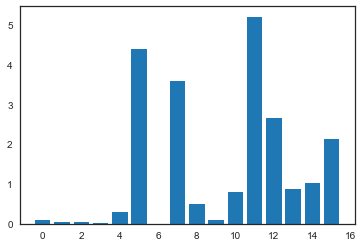

In [17]:
V = np.sum(Q,axis=1)
plt.bar(np.arange(len(V)),V)


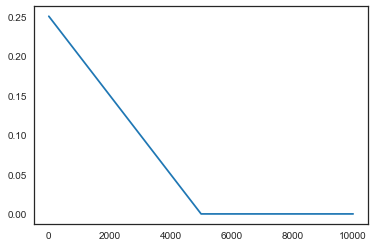

In [18]:
plt.plot(epsilons)

In [19]:
pi = np.argmax(Q,axis=1)
print(pi)

[0 3 1 3 0 2 2 2 3 1 0 0 1 2 1 1]


/Users/chris/Desktop/virtenv_deeprl/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


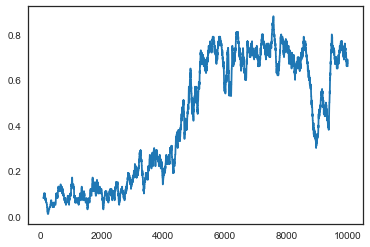

In [20]:
plt.plot(pd.rolling_mean(rewards[0:10000],100))

In [21]:
env.close()
gym.upload('/tmp/FrozenLake-v0-Q-learning/',api_key='sk_PP2R5NblSSaI9sECHDhu1g')

[2017-08-27 12:25:47,159] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/FrozenLake-v0-Q-learning')
[2017-08-27 12:25:47,174] [FrozenLake-v0] Uploading 10000 episodes of training data
[2017-08-27 12:25:50,818] [FrozenLake-v0] Uploading videos of 19 training episodes (2027 bytes)
[2017-08-27 12:25:50,962] [FrozenLake-v0] Creating evaluation object from /tmp/FrozenLake-v0-Q-learning/ with learning curve and training video
[2017-08-27 12:25:51,081] 
****************************************************
You successfully uploaded your evaluation on FrozenLake-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_NbmYrxfTRTmxwcL7505I7g

****************************************************


# State Approximation

In [61]:
env = gym.make('CartPole-v0')
observation = env.reset()
actions = env.action_space
env.close()
print(observation)
print(actions)

[2017-08-27 16:35:47,560] Making new env: CartPole-v0


[ 0.04553216 -0.02690051 -0.03901904  0.01043572]
Discrete(2)


- inspecting the action space and observation space

In [62]:
observations = []
for episode in range(1000):
    observation = env.reset()
    for t in range(100):
        #env.render()
        observations.append(observation)
        action = env.action_space.sample()
        if episode < 25:
            action = 1
        elif episode < 50:
            action = 0
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()
x_vals = np.array(observations)[:,0]
xd_vals = np.array(observations)[:,1]
a_vals = np.array(observations)[:,2]
ad_vals = np.array(observations)[:,3]
y = np.zeros_like(x_vals)

Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 11 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 11 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode 

limit_output extension: Maximum message size of 10000 exceeded with 10731 characters

(-0.15, 0.15)

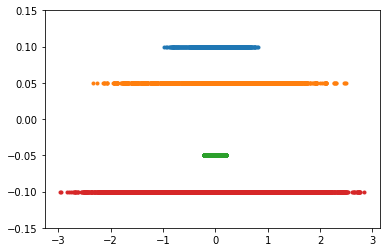

In [63]:
plt.plot(x_vals, y + 0.10, '.')
plt.plot(xd_vals, y + 0.05, '.')
plt.plot(a_vals, y - 0.05, '.')
plt.plot(ad_vals, y - 0.10, '.')

plt.ylim([-0.15, 0.15])

In [64]:
x_thres = ((env.env.observation_space.low/2)[0],
           (env.env.observation_space.high/2)[0])
a_thres = ((env.env.observation_space.low/2)[2],
           (env.env.observation_space.high/2)[2])

print(x_thres, a_thres)


(-2.3999999999999999, 2.3999999999999999) (-0.20943951023931953, 0.20943951023931953)


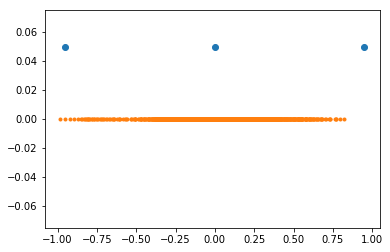

In [65]:
x1 = np.linspace(x_thres[0] + .5, x_thres[1] - .5, 
                  4, endpoint=False)[1:]
y1 = np.zeros(len(x1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(x1, y1, 'o')
plt.plot(x_vals, y, '.')

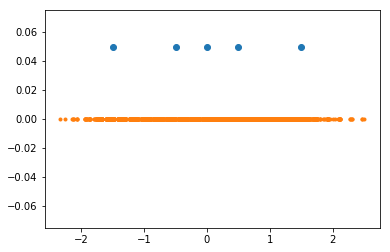

In [66]:
xd1 = np.sort(np.append(np.linspace(-1.5, 1.5, 4, endpoint=True), 0))
y1 = np.zeros(len(xd1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(xd1, y1, 'o')
plt.plot(xd_vals, y, '.')

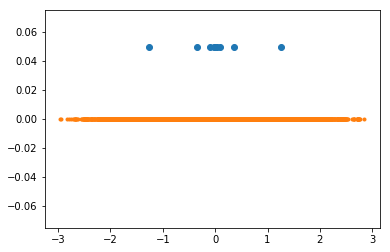

In [67]:
all_vals = np.sort(np.append(
    (np.logspace(-7, 4, 6, endpoint=False, base=2)[1:],
    -np.logspace(-7, 4, 6, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < 2)
ad1 = all_vals[idxs]
y1 = np.zeros(len(ad1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(ad1, y1, 'o')
plt.plot(ad_vals, y, '.')

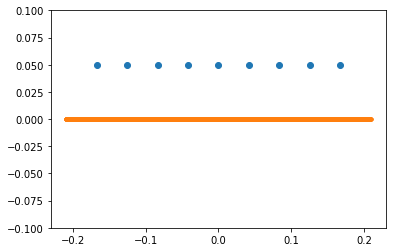

In [68]:

a1 = np.sort(np.linspace(a_thres[0], a_thres[1],
                         10, endpoint=False)[1:])
y1 = np.zeros(len(a1)) + 0.05

plt.ylim([-0.1, 0.1])
plt.plot(a1, y1, 'o')
plt.plot(a_vals, y, '.')

In [69]:
np.digitize(-0.1, a1)

array(2)

In [70]:
def learning_schedule(episode, n_episodes):
    return max(0., min(0.8, 1 - episode/n_episodes))

In [71]:
def action_selection(state, Q, episode, n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    if np.random.random() < epsilon:
        action = np.random.randint(Q.shape[1])
    else:
        action = np.argmax(Q[state])
    return action, epsilon

In [72]:
def observation_to_state(observation, bins):
    ss = []
    for i in range(len(observation)):
        ss.append(int(np.digitize(observation[i], bins=bins[i])))
    state = int("".join(map(lambda feature: str(int(feature)), ss)))
    return state

In [73]:
sample_states = [[0.33, 0.2, 0.1, 0.], 
                 [-0.33, 0.2, 0.1, 0.], 
                 [0.33, -0.2, 0.1, 0.], 
                 [0.33, 0.2, -0.1, 0.], 
                 [0.33, 0.2, 0.1, .99]]
for sample_state in sample_states:
    print(observation_to_state(sample_state, (x1, xd1, a1, ad1)))

2375
1375
2275
2325
2378


In [74]:
def q_learning(env, bins, gamma = 0.99):
    nS = 10 * 10 * 10 * 10
    nA = env.env.action_space.n
    
    Q = np.random.random((nS, nA)) - 0.5
    n_episodes = 5000
    
    alphas = []
    epsilons = []
    states = []
    actions = []
    for episode in range(n_episodes):
        observation = env.reset()
        state = observation_to_state(observation, bins)
    
        done = False
        while not done:
            states.append(state)
            
            action, epsilon = action_selection(state, Q, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            observation, reward, done, info = env.step(action)
            nstate = observation_to_state(observation, bins)
            
            alpha = learning_schedule(episode, n_episodes)
            alphas.append(alpha)
            
            Q[state][action] += alpha * (reward + gamma * Q[nstate].max() * (not done) - Q[state][action])
            state = nstate
    return Q, (alphas, epsilons, states, actions)

In [75]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

Q, stats = q_learning(env, (x1, xd1, a1, ad1))
env.render(close=True) ### NICE THIS WORKS 

[2017-08-27 16:35:56,378] Making new env: CartPole-v0
[2017-08-27 16:35:56,386] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp5zlau5au/openaigym.video.3.60986.video000000.mp4
[2017-08-27 16:35:56,825] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp5zlau5au/openaigym.video.3.60986.video000001.mp4
[2017-08-27 16:35:57,156] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp5zlau5au/openaigym.video.3.60986.video000008.mp4
[2017-08-27 16:35:57,646] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp5zlau5au/openaigym.video.3.60986.video000027.mp4
[2017-08-27 16:35:58,146] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp5zlau5au/openaigym.video.3.60986.video000064.mp4
[2017-08-27 16:35:58,647] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tm

In [76]:
import io
import base64
from IPython.display import HTML

In [77]:
videos = np.array(env.videos)

videos = videos[10,:]
videos[1]

'/var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp5zlau5au/openaigym.video.3.60986.video001000.meta.json'

In [78]:
videos = np.array(env.videos)

videos = videos[np.random.randint(len(videos)),:]

strm = ''
for video_path, meta_path in [videos]:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [79]:
strm

'\n    <h2>Episode 64<h2/>\n    <video width="960" height="540" controls>\n        <source src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAADA1tZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDEzOCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTMgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLj

In [42]:
V = np.max(Q, axis=1)
V


array([ 0.38440345,  2.89789467,  6.9182084 , ...,  0.14498346,
        0.44190829, -0.37710781])

In [43]:
V.max()

95.747616692314821

In [44]:
pi = np.argmax(Q, axis=1)
pi

array([1, 1, 0, ..., 1, 0, 1])

In [45]:
np.shape(Q)

(10000, 2)

In [46]:
env.close()
gym.upload(mdir, api_key='sk_PP2R5NblSSaI9sECHDhu1g')

[2017-08-27 12:26:57,992] Finished writing results. You can upload them to the scoreboard via gym.upload('/var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp_jvs508l')
[2017-08-27 12:26:58,002] [CartPole-v0] Uploading 5000 episodes of training data
[2017-08-27 12:27:00,730] [CartPole-v0] Uploading videos of 14 training episodes (66279 bytes)
[2017-08-27 12:27:02,015] [CartPole-v0] Creating evaluation object from /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp_jvs508l with learning curve and training video
[2017-08-27 12:27:02,220] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_WSnhtKYITcmz9KFLxQhURw

****************************************************


- he recommends better discretization etc. 

# Very Simple DQN 

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
from collections import deque
import random


In [3]:
def action_selection(state,model,episode,n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    
    # this is using the deep neural net to predict v(s+1)
    values = model.predict(state.reshape(1, state.shape[0]))[0]
    if np.random.random()<epsilon:
        action = np.random.randint(len(values))
    else:
        action = np.argmax(values)
    return action, epsilon
    

In [4]:
def neuro_q_learning(env, gamma = 0.99):
    nS = env.observation_space.shape[0]
    nA = env.env.action_space.n
    
    # memory bank
    memory_bank = deque()
    memory_bank_size = 100000
    
    # function approximator
    model = Sequential()
    model.add(Dense(128, input_dim=nS, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(nA, activation='linear'))
    model.compile(loss='mse', optimizer='adam')

    # constant values
    n_episodes = 50000
    batch_size = 256
    training_frequency = 20
    
    # for statistics
    epsilons = []
    states = []
    actions = []
    
    # interactions
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        
        # each episode
        while not done:
            states.append(state)
            
            # select action
            action, epsilon = action_selection(state, model, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            # save history in memory bank
            nstate, reward, done, info = env.step(action)
            memory_bank.append((state, action, reward, nstate, done))
            if len(memory_bank) > memory_bank_size:
                memory_bank.popleft()
            
            # iterate to next state
            state = nstate

        # only every few episodes enter training and update neural network weights
        if episode % training_frequency == 0 and len(memory_bank) == memory_bank_size:
            
            # randomly select batches of samples from the history
            # for training to prevent values spiking due to high 
            # correlation of sequential values
            minibatch = np.array(random.sample(memory_bank, batch_size))

            # extract values by type from the minibatch
            state_batch = np.array(minibatch[:,0].tolist())
            action_batch = np.array(minibatch[:,1].tolist())
            rewards_batch = np.array(minibatch[:,2].tolist())
            state_prime_batch = np.array(minibatch[:,3].tolist())
            is_terminal_batch = np.array(minibatch[:,4].tolist())

            # use the current neural network to predict 
            # current state values and next state values
            state_value_batch = model.predict(state_batch)
            next_state_value_batch = model.predict(state_prime_batch)

            # update the state values given the batch
            for i in range(len(minibatch)):
                if is_terminal_batch[i]:
                    state_value_batch[i, action_batch[i]] = rewards_batch[i]
                else:
                    state_value_batch[i, action_batch[i]] = rewards_batch[i] + gamma * np.max(next_state_value_batch[i])
            
            # update the neural network weights
            model.train_on_batch(state_batch, state_value_batch)

    return model, (epsilons, states, actions)

In [10]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)


[2017-08-27 15:17:10,739] Making new env: CartPole-v0


In [11]:
model, stats = neuro_q_learning(env)

[2017-08-27 15:17:13,107] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video000000.mp4
[2017-08-27 15:17:14,956] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video000001.mp4
[2017-08-27 15:17:15,301] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video000008.mp4
[2017-08-27 15:17:16,035] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video000027.mp4
[2017-08-27 15:17:16,754] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video000064.mp4
[2017-08-27 15:17:17,728] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video000125.mp4
[201

[2017-08-27 15:33:26,778] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video041000.mp4
[2017-08-27 15:33:50,881] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video042000.mp4
[2017-08-27 15:35:00,499] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video043000.mp4
[2017-08-27 15:36:31,239] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video044000.mp4
[2017-08-27 15:38:03,583] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video045000.mp4
[2017-08-27 15:39:41,374] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c/openaigym.video.0.60986.video046000.mp4
[201

In [12]:
env.render(close=True) ### NICE THIS WORKS 

In [19]:
env.close()

[2017-08-27 16:26:07,487] Finished writing results. You can upload them to the scoreboard via gym.upload('/var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c')


In [20]:
gym.upload(mdir, api_key='sk_PP2R5NblSSaI9sECHDhu1g')

[2017-08-27 16:26:18,965] [CartPole-v0] Uploading 50000 episodes of training data
[2017-08-27 16:26:24,366] [CartPole-v0] Uploading videos of 59 training episodes (282393 bytes)
[2017-08-27 16:26:24,970] [CartPole-v0] Creating evaluation object from /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpzm2iv98c with learning curve and training video
[2017-08-27 16:26:25,143] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_3TfbEYMCQLiEvL5D00pelQ

****************************************************


In [24]:
epsilons, states, actions = stats

In [30]:
np.shape(states)

(3437140, 4)

In [81]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

for episode in range(100):
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(model.predict(state.reshape(1, 4))[0])
        nstate, reward, done, info = env.step(action)
        state = nstate

[2017-08-27 16:37:39,795] Making new env: CartPole-v0
[2017-08-27 16:37:39,840] Finished writing results. You can upload them to the scoreboard via gym.upload('/var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp5zlau5au')
[2017-08-27 16:37:39,843] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpyzfmabxu/openaigym.video.4.60986.video000000.mp4
[2017-08-27 16:37:41,735] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpyzfmabxu/openaigym.video.4.60986.video000001.mp4
[2017-08-27 16:37:43,848] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpyzfmabxu/openaigym.video.4.60986.video000008.mp4
[2017-08-27 16:37:48,195] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmpyzfmabxu/openaigym.video.4.60986.video000027.mp4
[2017-08-27 16:37:52,327] Starting new video recorder writing to /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T

In [82]:
env.render(close=True) ### NICE THIS WORKS 

In [83]:
import io
import base64
from IPython.display import HTML

In [84]:
videos = np.array(env.videos)

videos = videos[np.random.randint(len(videos)),:]

strm = ''
for video_path, meta_path in [videos]:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

limit_output extension: Maximum message size of 10000 exceeded with 19919 characters

In [35]:
env.close()

[2017-08-27 16:28:36,151] Finished writing results. You can upload them to the scoreboard via gym.upload('/var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp0qo4j8oq')


In [36]:
gym.upload(mdir, api_key='sk_PP2R5NblSSaI9sECHDhu1g')

[2017-08-27 16:28:41,751] [CartPole-v0] Uploading 100 episodes of training data
[2017-08-27 16:28:42,710] [CartPole-v0] Uploading videos of 5 training episodes (51688 bytes)
[2017-08-27 16:28:43,338] [CartPole-v0] Creating evaluation object from /var/folders/h5/n0m4g__513d80_1dp1xsxrb40000gn/T/tmp0qo4j8oq with learning curve and training video
[2017-08-27 16:28:43,495] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_5Ef3ktEdS6S3ZVdZCSogg

****************************************************
